# Good Controls: Variance Reduction

**Chapter 7, Section 1**

This notebook covers how adding controls that predict the outcome (but not treatment) reduces standard errors without introducing bias.

## Table of Contents
1. [Intuition](#intuition) - Controls that predict Y help
2. [Formal Treatment](#formal) - FWL and variance decomposition
3. [Numeric Demonstration](#numeric) - Email campaign example
4. [Implementation](#implementation) - Partialling out in practice
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### When Controls Help (Without Being Confounders)

Consider an RCT: treatment $T$ is randomly assigned, so there's no confounding. Why would we add controls?

**Answer**: Controls that predict the outcome $Y$ **reduce residual variance**, leading to:
- Smaller standard errors
- Narrower confidence intervals
- More statistical power

This is the **variance reduction** argument:

$$\text{Var}(Y | X) < \text{Var}(Y)$$

If $X$ explains part of $Y$'s variance, the residual variance $\sigma^2_{Y|X}$ is smaller.

★ Insight ─────────────────────────────────────
- Good controls predict **Y**, not (or not only) **T**
- In an RCT, controls aren't needed for unbiasedness
- But they increase precision (statistical power)
- Key: Adding good controls ≠ changing the coefficient
─────────────────────────────────────────────────

In [2]:
# Load collections email data (5,000 customers)
email = load_facure_data("collections_email.csv")

print(f"Data: {len(email)} customers")
print(f"Treatment (email): {email['email'].mean():.1%} received email")
print(f"\nColumns: {list(email.columns)}")
email.head()

Data: 5000 customers
Treatment (email): 49.1% received email

Columns: ['payments', 'email', 'opened', 'agreement', 'credit_limit', 'risk_score']


,payments,email,opened,agreement,credit_limit,risk_score
0,740,1,1.0000,0.0000,2348.4953,0.6668
1,580,1,1.0000,1.0000,334.1120,0.2074
2,600,1,1.0000,1.0000,1360.6607,0.5505
3,770,0,0.0000,0.0000,1531.8286,0.5605
4,660,0,0.0000,0.0000,979.8556,0.4551


In [3]:
# This is an RCT - email was randomly assigned
# Verify randomization by checking balance
print("Balance check (means by treatment):")
balance = email.groupby('email')[['credit_limit', 'risk_score']].mean()
print(balance)
print(f"\nDifference (email=1 minus email=0):")
diff = balance.loc[1] - balance.loc[0]
print(f"  credit_limit: {diff['credit_limit']:.2f}")
print(f"  risk_score:   {diff['risk_score']:.4f}")

Balance check (means by treatment):
       credit_limit  risk_score
email                          
0         1211.3709      0.4830
1         1177.6999      0.4785

Difference (email=1 minus email=0):
  credit_limit: -33.67
  risk_score:   -0.0045


---

## Formal Treatment

### Why Good Controls Reduce Standard Errors

Consider the regression:

$$Y = \alpha + \beta T + \gamma X + \epsilon$$

The standard error of $\hat{\beta}$ is:

$$SE(\hat{\beta}) = \sqrt{\frac{\hat{\sigma}^2_{\epsilon}}{\sum_i (T_i - \bar{T})^2 \cdot (1 - R^2_{T \sim X})}}$$

**Two effects of adding X**:

| Component | Effect of Adding X | Net Result |
|-----------|-------------------|------------|
| $\hat{\sigma}^2_{\epsilon}$ | **Decreases** if X predicts Y | ↓ SE |
| $R^2_{T \sim X}$ | **Increases** if X predicts T | ↑ SE |

**Good control**: X predicts Y strongly, T weakly → Net SE reduction

**Bad control**: X predicts T strongly, Y weakly → Net SE increase

### FWL Perspective

By Frisch-Waugh-Lovell, $\hat{\beta}$ comes from:

$$\tilde{Y} = \beta \tilde{T} + \epsilon$$

where $\tilde{Y}$ and $\tilde{T}$ are residuals after partialling out X.

- If X explains Y variance → $\text{Var}(\tilde{Y})$ smaller → smaller SE
- If X explains T variance → $\text{Var}(\tilde{T})$ smaller → **larger SE** (denominator shrinks)

In [4]:
# Model 1: No controls (simple treatment effect)
model_simple = smf.ols('payments ~ email', data=email).fit()

# Model 2: With good controls (credit_limit, risk_score)
model_controls = smf.ols('payments ~ email + credit_limit + risk_score', data=email).fit()

print("COMPARISON: Simple vs With Controls")
print("=" * 55)
print(f"\nTreatment Effect (email → payments):")
print(f"  Without controls: {model_simple.params['email']:.2f} (SE: {model_simple.bse['email']:.2f})")
print(f"  With controls:    {model_controls.params['email']:.2f} (SE: {model_controls.bse['email']:.2f})")
print(f"\nSE reduction: {(1 - model_controls.bse['email']/model_simple.bse['email'])*100:.1f}%")
print(f"R² increase: {model_simple.rsquared:.4f} → {model_controls.rsquared:.4f}")

COMPARISON: Simple vs With Controls

Treatment Effect (email → payments):
  Without controls: -0.62 (SE: 2.94)
  With controls:    4.43 (SE: 2.13)

SE reduction: 27.6%
R² increase: 0.0000 → 0.4774


---

## Numeric Demonstration

### Variance Decomposition

In [5]:
# Decompose variance reduction
var_Y_total = email['payments'].var()
var_Y_residual_simple = model_simple.resid.var()
var_Y_residual_controls = model_controls.resid.var()

print("Variance Decomposition:")
print(f"  Total Var(Y):           {var_Y_total:.2f}")
print(f"  Residual (no controls): {var_Y_residual_simple:.2f}")
print(f"  Residual (controls):    {var_Y_residual_controls:.2f}")
print(f"\nVariance explained by controls: {(1 - var_Y_residual_controls/var_Y_residual_simple)*100:.1f}%")

Variance Decomposition:
  Total Var(Y):           10809.77
  Residual (no controls): 10809.68
  Residual (controls):    5648.69

Variance explained by controls: 47.7%


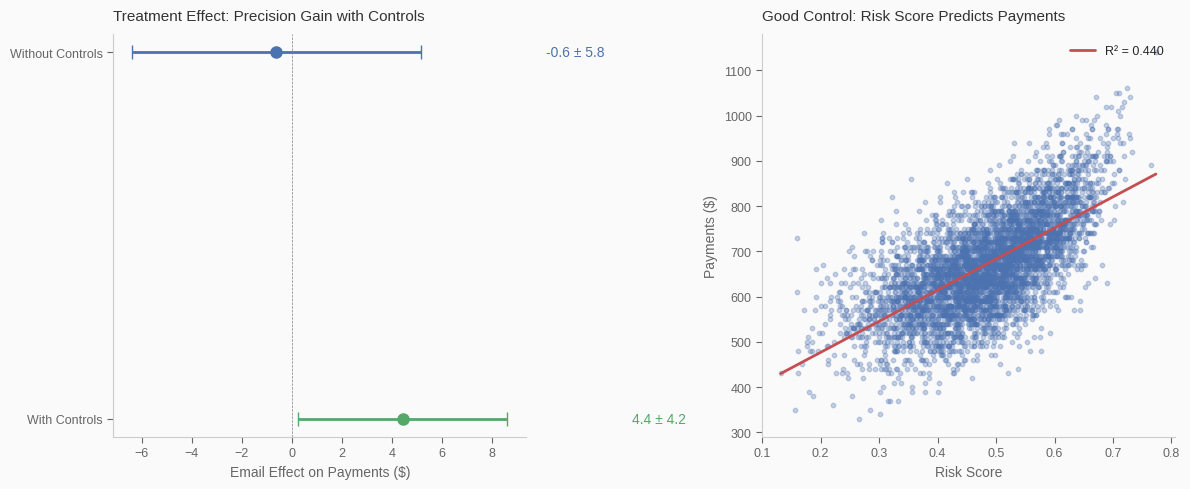

In [6]:
# Visualize the precision gain
fig, axes = create_tufte_figure(ncols=2, figsize=(12, 5))

# Left: Confidence intervals comparison
ax = axes[0]

models = ['Without Controls', 'With Controls']
effects = [model_simple.params['email'], model_controls.params['email']]
ci_lower = [model_simple.conf_int().loc['email', 0], model_controls.conf_int().loc['email', 0]]
ci_upper = [model_simple.conf_int().loc['email', 1], model_controls.conf_int().loc['email', 1]]

y_pos = [1, 0]
for i, (model, effect, lo, hi) in enumerate(zip(models, effects, ci_lower, ci_upper)):
    color = COLORS['blue'] if i == 0 else COLORS['green']
    ax.errorbar(effect, y_pos[i], xerr=[[effect-lo], [hi-effect]], 
                fmt='o', color=color, capsize=5, markersize=8, linewidth=2)
    ax.text(hi + 5, y_pos[i], f'{effect:.1f} ± {(hi-lo)/2:.1f}', 
            va='center', fontsize=10, color=color)

ax.set_yticks(y_pos)
ax.set_yticklabels(models)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
set_tufte_title(ax, "Treatment Effect: Precision Gain with Controls")
set_tufte_labels(ax, "Email Effect on Payments ($)", "")

# Right: How controls predict outcome
ax = axes[1]

# Show correlation between controls and outcome
ax.scatter(email['risk_score'], email['payments'], alpha=0.3, s=10, c=COLORS['blue'])

# Add regression line
x_range = np.linspace(email['risk_score'].min(), email['risk_score'].max(), 100)
risk_model = smf.ols('payments ~ risk_score', data=email).fit()
ax.plot(x_range, risk_model.params['Intercept'] + risk_model.params['risk_score'] * x_range,
        color=COLORS['red'], linewidth=2, label=f'R² = {risk_model.rsquared:.3f}')

set_tufte_title(ax, "Good Control: Risk Score Predicts Payments")
set_tufte_labels(ax, "Risk Score", "Payments ($)")
ax.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

In [7]:
# Check that controls don't predict treatment (RCT verification)
model_predict_T = smf.ols('email ~ credit_limit + risk_score', data=email).fit()

print("Do controls predict treatment? (Should be ~0 for RCT)")
print(f"R² of email ~ credit_limit + risk_score: {model_predict_T.rsquared:.6f}")
print(f"\nThis confirms random assignment: controls don't predict who got email.")

Do controls predict treatment? (Should be ~0 for RCT)
R² of email ~ credit_limit + risk_score: 0.002926

This confirms random assignment: controls don't predict who got email.


### Control Variable Decision Tree

| Variable Type | Control? | Effect on SE | Effect on $\hat{\beta}$ |
|--------------|----------|--------------|------------------------|
| **Confounder** (X → T, X → Y) | ✅ YES | Mixed | Removes bias |
| **Outcome predictor** (X → Y only) | ✅ YES | ↓ Decreases | No change (RCT) |
| **Treatment predictor** (X → T only) | ❌ NO | ↑ Increases | No change (RCT) |
| **Collider** (T → X ← Y) | ❌ NO | Mixed | Introduces bias |
| **Mediator** (T → X → Y) | ❌ NO | Mixed | Blocks causal path |

---

## Implementation

### FWL Demonstration: Partialling Out

In [8]:
# Demonstrate FWL: partialling out gives same coefficient

# Step 1: Regress Y on controls, get residuals
model_Y_on_X = smf.ols('payments ~ credit_limit + risk_score', data=email).fit()
Y_tilde = model_Y_on_X.resid

# Step 2: Regress T on controls, get residuals
model_T_on_X = smf.ols('email ~ credit_limit + risk_score', data=email).fit()
T_tilde = model_T_on_X.resid

# Step 3: Regress Y~ on T~
residuals_df = pd.DataFrame({'Y_tilde': Y_tilde, 'T_tilde': T_tilde})
model_fwl = smf.ols('Y_tilde ~ T_tilde - 1', data=residuals_df).fit()  # No intercept

print("FWL Verification:")
print(f"  Full regression β: {model_controls.params['email']:.10f}")
print(f"  FWL (partialled):  {model_fwl.params['T_tilde']:.10f}")
print(f"  Match: {np.isclose(model_controls.params['email'], model_fwl.params['T_tilde'])}")

FWL Verification:
  Full regression β: 4.4303556770
  FWL (partialled):  4.4303556770
  Match: True


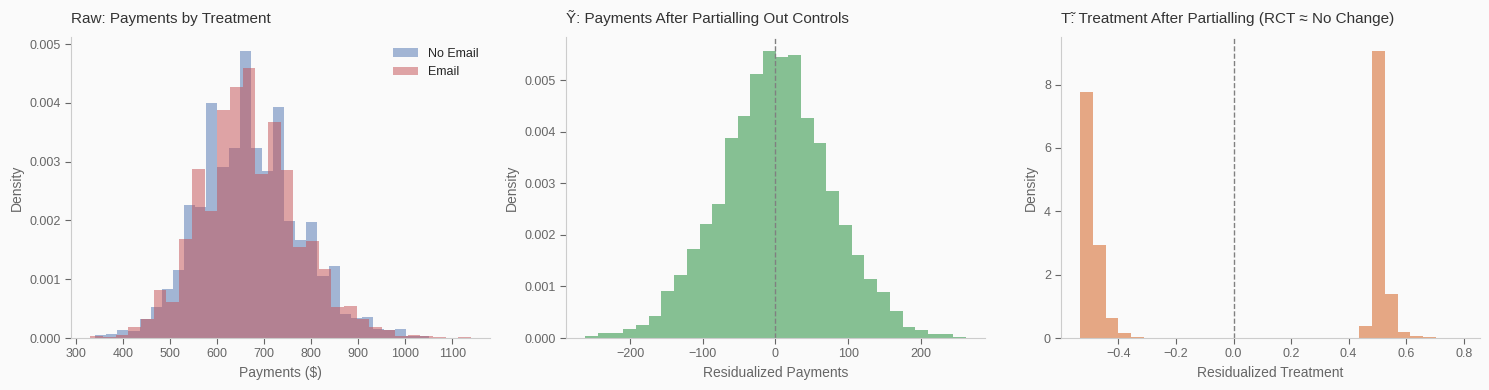


Variance comparison:
  Var(Y):  10809.77
  Var(Ỹ): 5653.58 (reduced by 47.7%)
  Var(T):  0.2500
  Var(T̃): 0.2492 (unchanged for RCT)


In [9]:
# Visualize the partialling out process
fig, axes = create_tufte_figure(ncols=3, figsize=(15, 4))

# Left: Raw Y vs T
ax = axes[0]
for t_val, color, label in [(0, COLORS['blue'], 'No Email'), (1, COLORS['red'], 'Email')]:
    subset = email[email['email'] == t_val]
    ax.hist(subset['payments'], bins=30, alpha=0.5, color=color, label=label, density=True)
set_tufte_title(ax, "Raw: Payments by Treatment")
set_tufte_labels(ax, "Payments ($)", "Density")
ax.legend(frameon=False)

# Middle: Residualized Y
ax = axes[1]
ax.hist(Y_tilde, bins=30, alpha=0.7, color=COLORS['green'], density=True)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
set_tufte_title(ax, "Ỹ: Payments After Partialling Out Controls")
set_tufte_labels(ax, "Residualized Payments", "Density")

# Right: Residualized T (should be ~centered at 0.5 for RCT)
ax = axes[2]
ax.hist(T_tilde, bins=30, alpha=0.7, color=COLORS['orange'], density=True)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
set_tufte_title(ax, "T̃: Treatment After Partialling (RCT ≈ No Change)")
set_tufte_labels(ax, "Residualized Treatment", "Density")

plt.tight_layout()
plt.show()

print(f"\nVariance comparison:")
print(f"  Var(Y):  {email['payments'].var():.2f}")
print(f"  Var(Ỹ): {Y_tilde.var():.2f} (reduced by {(1-Y_tilde.var()/email['payments'].var())*100:.1f}%)")
print(f"  Var(T):  {email['email'].var():.4f}")
print(f"  Var(T̃): {T_tilde.var():.4f} (unchanged for RCT)")

---

## Interview Appendix

### Practice Questions

**Q1: When do additional controls help causal inference?**

<details>
<summary>Solution</summary>

Additional controls help in two distinct ways:

**1. Removing confounding bias** (observational data):
- Control for common causes of T and Y
- Blocks backdoor paths in the DAG
- Necessary for identification

**2. Reducing variance** (RCT or observational):
- Control for variables that predict Y (but not necessarily T)
- Reduces residual variance → smaller SE
- Increases statistical power
- **Not** necessary for unbiasedness in RCT

**Key insight**: In an RCT, controls aren't needed for unbiasedness (treatment is random), but they help with precision. A variable that strongly predicts Y will reduce SE even if it has zero correlation with T.

</details>

**Q2: Why might adding a control variable INCREASE standard errors?**

<details>
<summary>Solution</summary>

A control variable increases SE when it **predicts T more than it predicts Y** (after conditioning on T).

**Mathematical reason**:
$$SE(\hat{\beta}_T) \propto \frac{\sigma_{\epsilon}}{\sqrt{\text{Var}(\tilde{T})}}$$

If X predicts T:
- $\text{Var}(\tilde{T}) = \text{Var}(T) \cdot (1 - R^2_{T \sim X})$ decreases
- Denominator shrinks → SE increases

This is why we call these "bad controls" even if they're pre-treatment—they reduce the effective variation in treatment.

**Example**: Controlling for "intention to treat" in a drug trial. It predicts T (compliance) but not Y|T.

</details>

**Q3: How does FWL explain the variance reduction from controls?**

<details>
<summary>Solution</summary>

FWL shows that $\hat{\beta}_T$ from the full regression equals the coefficient from:

$$\tilde{Y} = \beta_T \tilde{T} + \epsilon$$

where $\tilde{Y}$ and $\tilde{T}$ are residuals after partialling out X.

**Variance reduction mechanism**:

1. If X predicts Y: $\text{Var}(\tilde{Y}) < \text{Var}(Y)$
   - Less "noise" in outcome → cleaner signal
   - Residual variance in final regression is smaller

2. If X predicts T: $\text{Var}(\tilde{T}) < \text{Var}(T)$
   - Less variation in treatment → harder to identify effect
   - Denominator shrinks → SE increases

**Net effect** depends on relative predictive power for Y vs T.

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 7.

[^2]: Angrist, J. D., & Pischke, J.-S. (2009). *Mostly Harmless Econometrics*, Section 3.2.3.

[^3]: Cross-reference: FWL theorem in `05_linear_regression/02_regression_theory.ipynb`